# __I. Setup__

## i. Imports

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-12 22:35:39.473232: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 22:35:41.318552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734014141.392012     827 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734014141.412012     827 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 22:35:39.947736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## ii. GPU

### a. Check if GPU is available

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4688755943717298070
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5833228288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5570238961737813941
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1734014143.455630     827 gpu_device.cc:2022] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### b. Limit memory on GPU

In [3]:
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
    tf.config.experimental.set_memory_growth(gpu, True)

# __II. Data Preprocessing__

## i. Define dataset path and classes

In [4]:
DATA_DIR = Path("BiNet_Dataset")
CLASSES = ["Corrosionstain", "Cracks", "Exposedbars", "Spalling"]

## ii. Remove corrupted files

In [5]:
def remove_corrupted_files(data_dir, classes):
    for class_name in classes:
        class_dir = data_dir / class_name
        for img_file in class_dir.iterdir():
            try:
                img = Image.open(img_file)
                img.verify()  # Verify integrity
            except (IOError, SyntaxError):
                print(f"Removing corrupted file: {img_file}")
                os.remove(img_file)

remove_corrupted_files(DATA_DIR, CLASSES)

## iii. Check class distribution

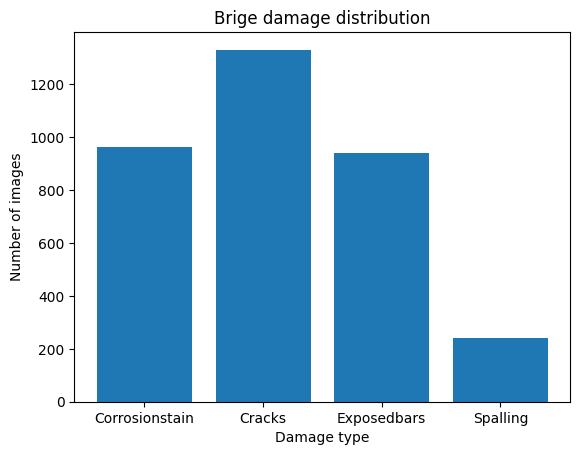

dict_values([961, 1330, 940, 240])

In [6]:
class_counts = {class_name: len(list((DATA_DIR / class_name).glob("*.png"))) for class_name in CLASSES}
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Brige damage distribution")
plt.xlabel("Damage type")
plt.ylabel("Number of images")
plt.show()
class_counts.values()

Class imbalance is present. It will be addressed using weights.

## iv. Split dataset

### a. Function to split dataset into training(70%), valuation(10%), and testing sets(20%).

In [7]:
def split_data(data_dir, classes, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    train_dir = data_dir / "train"
    val_dir = data_dir / "val"
    test_dir = data_dir / "test"

    for dir_path in [train_dir, val_dir, test_dir]:
        dir_path.mkdir(exist_ok=True, parents=True)

    for class_name in classes:
        all_files = list((data_dir / class_name).glob("*.png"))
        np.random.shuffle(all_files)

        train_count = int(len(all_files) * train_ratio)
        val_count = int(len(all_files) * val_ratio)

        train_files = all_files[:train_count]
        val_files = all_files[train_count:train_count + val_count]
        test_files = all_files[train_count + val_count:]

        for subset, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
            subset_class_dir = subset / class_name
            subset_class_dir.mkdir(exist_ok=True)
            for file in files:
                shutil.copy(file, subset_class_dir)

split_data(DATA_DIR, CLASSES)            

### b. Declare directory variables 

In [8]:
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

### c. Declare class variables for the data sets

In [9]:
def get_class_dir(dir):
    class1_dir = dir / "Corrosionstain"
    class2_dir = dir / "Cracks"
    class3_dir = dir / "Exposedbars"
    class4_dir = dir / "Spalling"
    return class1_dir, class2_dir, class3_dir, class4_dir

TRAIN_CORROSIONSTAIN_DIR, TRAIN_CRACKS_DIR, TRAIN_EXPOSEDBARS_DIR, TRAIN_SPALLING_DIR  = get_class_dir(TRAIN_DIR)
VAL_CORROSIONSTAIN_DIR, VAL_CRACKS_DIR, VAL_EXPOSEDBARS_DIR, VAL_SPALLING_DIR  = get_class_dir(VAL_DIR)
TEST_CORROSIONSTAIN_DIR, TEST_CRACKS_DIR, TEST_EXPOSEDBARS_DIR, TEST_SPALLING_DIR  = get_class_dir(TEST_DIR)

### d. Check the number of images in the sets  

In [10]:
def dir_len(dir):
    return len(os.listdir(dir))

print("Training Set:")
print("   Corrosionstain: " + str(dir_len(TRAIN_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(TRAIN_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(TRAIN_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(TRAIN_SPALLING_DIR)) + " images")

print("\nValuation Set:")
print("   Corrosionstain: " + str(dir_len(VAL_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(VAL_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(VAL_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(VAL_SPALLING_DIR)) + " images")

print("\nTesting Set:")
print("   Corrosionstain: " + str(dir_len(TEST_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(TEST_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(TEST_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(TEST_SPALLING_DIR)) + " images")

Training Set:
   Corrosionstain: 960 images
   Cracks: 1329 images
   Exposedbars: 939 images
   Spalling: 240 images

Valuation Set:
   Corrosionstain: 452 images
   Cracks: 626 images
   Exposedbars: 436 images
   Spalling: 112 images

Testing Set:
   Corrosionstain: 703 images
   Cracks: 977 images
   Exposedbars: 694 images
   Spalling: 183 images


## v. Create Generators

### a. Data augmentation for training data

In [11]:
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='float32'
)

### b. Rescale for validation and test data

In [12]:
val_test_gen = ImageDataGenerator(
    rescale=1.0/255,
    dtype='float32'  
)

### c. Load data using generators

In [13]:
IMG_WIDTH = IMG_HEIGHT = 224
BATCH_SIZE = 64

train_generator = data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3468 images belonging to 4 classes.
Found 1626 images belonging to 4 classes.
Found 2557 images belonging to 4 classes.


### d. Address class imbalance using weights

In [14]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.903125), 1: np.float64(0.6523702031602708), 2: np.float64(0.9233226837060703), 3: np.float64(3.6125)}


## vi. Data visualization

### a. Show sample images from training set

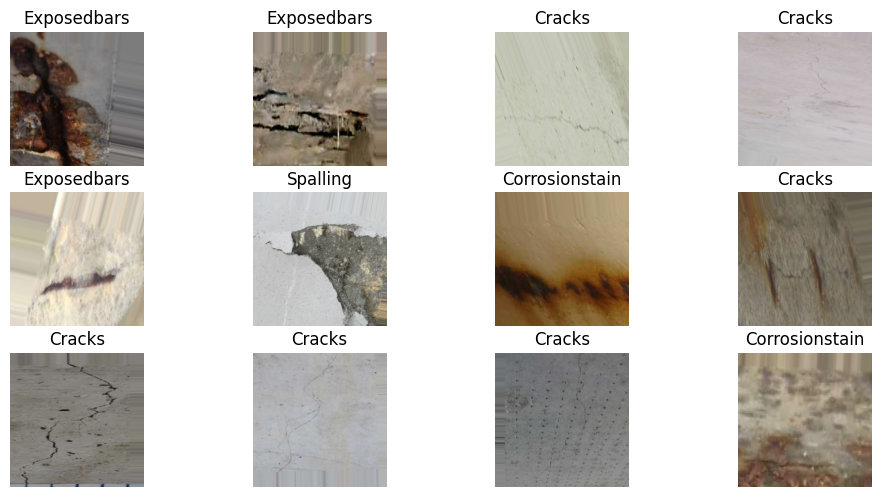

In [15]:
def plot_sample_images(generator, class_labels):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

class_labels = list(train_generator.class_indices.keys())
plot_sample_images(train_generator, class_labels)

# __III. Convolutional Neural Networks: 14 Model Trials__

### Function for model accuracy and loss plot

In [16]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

## i. Trial 1: model_uno

### a. Model creation

In [17]:
model_uno = models.Sequential()
model_uno.add(layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))) 

model_uno.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_uno.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_uno.add(layers.Flatten())

model_uno.add(layers.Dense(128, activation='relu'))
model_uno.add(layers.Dense(len(CLASSES), activation='softmax'))  

model_uno.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1734014151.595905     827 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### b. Model summary

In [18]:
model_uno.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    50,466,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,468,356 (192.52 MB)

 Trainable params: 50,468,356 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

### c. Model fitting

In [20]:
model_uno_history = model_uno.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, 
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 665ms/step - accuracy: 0.5271 - loss: 1.1132 - val_accuracy: 0.6451 - val_loss: 1.0183
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 670ms/step - accuracy: 0.6007 - loss: 1.0071 - val_accuracy: 0.6138 - val_loss: 1.0137
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 615ms/step - accuracy: 0.6488 - loss: 0.9688 - val_accuracy: 0.5726 - val_loss: 1.0681
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 665ms/step - accuracy: 0.6601 - loss: 0.8956 - val_accuracy: 0.6833 - val_loss: 0.8603
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 669ms/step - accuracy: 0.6692 - loss: 0.9074 - val_accuracy: 0.6728 - val_loss: 0.8966
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 668ms/step - accuracy: 0.7008 - loss: 0.8527 - val_accuracy: 0.7331 - val_loss: 0.7682
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 667ms/step - accuracy: 0.6876 - loss: 0.8559 - val_accuracy: 0.7411 - val_loss: 0.7876
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 631ms/step - accuracy: 0.6942 - loss: 0.8341 - val_accu

### d. Model history 

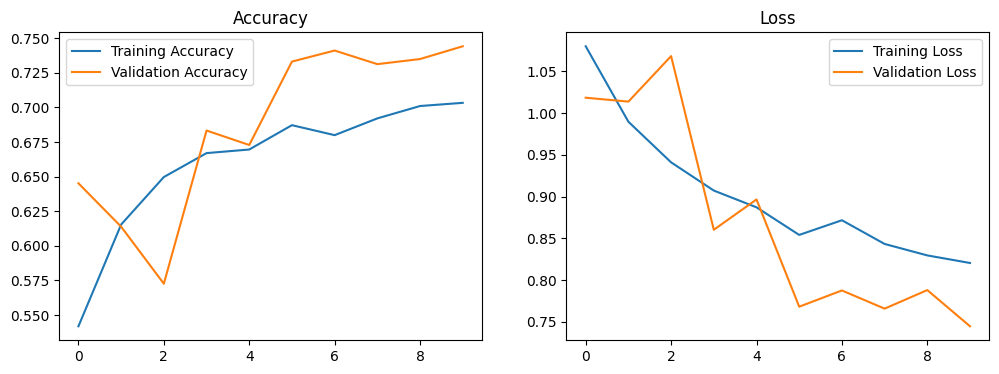

In [21]:
plot_training_history(model_uno_history)